# README: Calculating and Plotting COARE Fluxes Using RAMA Mooring Data

This repository provides tools to **prepare RAMA mooring data**, run the **COARE 3.6 bulk flux algorithm**, and **visualize air-sea fluxes**.

## Workflow Overview

1. **Prepare Input Data**

   - Load RAMA NetCDF files containing meteorological and oceanographic variables.
   - Convert them into the required COARE input format:
     - Julian day (`jd`)
     - Wind speed (`u`) and measurement height (`zu`)
     - Air temperature (`ta`) and humidity (`rh`) at height (`zt`, `zq`)
     - Sea surface temperature (`tsnk`) and salinity (`Ss`)
     - Downward shortwave (`sw_dn`) and longwave radiation (`lw_dn`)
     - Pressure (`P`)
     - Rainfall (`rain`)
     - Position (`lat`, `lon`)
     - Boundary layer height (`zi`)
     - Optional wave parameters (`cp`, `sigH`)
     - Subsurface temperature (`tsg`) and depth (`ztsg`)
   - Save the input dataset as `test_data.txt`.

2. **Run COARE Algorithm** *(optional step in script)*

   - The input file can be passed to the function `coare36_sample.py` to compute fluxes:
     - Wind stress (`tau`)
     - Sensible heat flux (`hsb`)
     - Latent heat flux (`hlb`)
     - Transfer coefficients (`Cd`, `Ch`, `Ce`)
     - Stability parameters (`L`, `zet`) and more.
   - Output can be saved in a text or CSV file.

3. **Plot Fluxes**

   - Read COARE output file with `pandas.read_csv()`.
   - Plot key variables:
     - Wind stress, sensible heat, latent heat (`tau`, `hsb`, `hlb`).
   - Save plots to PNG files inside a `plots/` directory.

**Import libraries** → for data handling (`xarray`, `pandas`, `numpy`) and plotting (`matplotlib`).

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import math
from matplotlib.patches import Arc
import xarray as xr

**Define path of observation**

In [330]:
path     = '/home/rohit/Downloads/PIRATA_19S_34W/'
location = '19s34w'
# Example observation coordinates (lat, lon)
lats   = [0]
lons   = [-140]

#region = [50, 100, -10, 27]  # Indian Ocean
#region = [-180, -70, -20, 20] # Pacific Ocean
region = [-180, -70, -20, 20] # Atlantic Ocean

**Plot observation location**

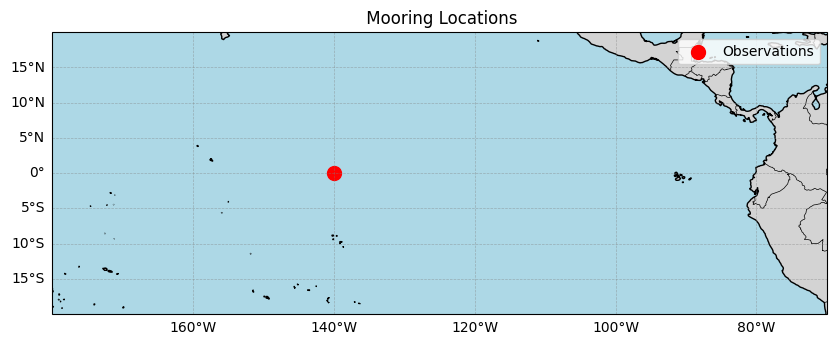

In [331]:
# Set up the map projection
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=proj)

# Set extent for Indian Ocean (lon_min, lon_max, lat_min, lat_max)
ax.set_extent(region, crs=proj) # Indian Ocean region

# Add coastlines and features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot observation points
ax.scatter(lons, lats, color='red', s=100, marker='o', transform=proj, label='Observations')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.legend()
plt.title(" Mooring Locations")
plt.show()

**Load NetCDF files** → open RAMA variables using `xr.open_dataset()`.

In [332]:
# Load RAMA NetCDF variables (adjust paths)
sw   = xr.open_dataset(str(path)+'rad'+str(location)+'_dy.cdf').RD_495
lw   = xr.open_dataset(str(path)+'lw'+str(location)+'_dy.cdf').Ql_136
sst  = xr.open_dataset(str(path)+'sst'+str(location)+'_dy.cdf').T_25
sss  = xr.open_dataset(str(path)+'sss'+str(location)+'_dy.cdf').S_41
airt = xr.open_dataset(str(path)+'airt'+str(location)+'_dy.cdf').AT_21
rh   = xr.open_dataset(str(path)+'rh'+str(location)+'_dy.cdf').RH_910
pres = xr.open_dataset(str(path)+'bp'+str(location)+'_dy.cdf').BP_915
wsp  = xr.open_dataset(str(path)+'w'+str(location)+'_dy.cdf').WS_401
rain = xr.open_dataset(str(path)+'rain'+str(location)+'_dy.cdf').RN_485
lat  = xr.open_dataset(str(path)+'pos'+str(location)+'_dy.cdf').LAT_500
lon  = xr.open_dataset(str(path)+'pos'+str(location)+'_dy.cdf').LON_502

**Build COARE input** → align datasets on time, convert units, set measurement heights.

In [333]:
# Align on common time index
df = pd.concat([
    sw[:,0,0,0].to_series(), lw[:,0,0,0].to_series(), sst[:,0,0,0].to_series(), sss[:,0,0,0].to_series(),
    airt[:,0,0,0].to_series(), rh[:,0,0,0].to_series(), pres[:,0,0,0].to_series(), wsp[:,0,0,0].to_series(),
    rain[:,0,0,0].to_series(), lat[:,0,0,0].to_series(),lon[:,0,0,0].to_series(),
], axis=1, keys=["sw", "lw", "sst", "sss", "airt", "rh", "pres", "wsp", "rain","lat","lon"])

df   = df.dropna()
time = pd.to_datetime(df.index)

# Constants / sensor heights
zu, zt, zq = 10.0, 2.0, 2.0
zi         = 600.0

# Lat/Lon constant from files (assuming fixed mooring)
latval = df["lat"]
lonval = df["lon"]

# Build COARE inputs
jd = time.to_julian_date().to_numpy()
coare_input = pd.DataFrame({
    "jd": jd,
    "u": df["wsp"].values,
    "zu": zu,
    "ta": df["airt"].values,
    "zt": zt,
    "rh": df["rh"].values,
    "zq": zq,
    "P": df["pres"].values,  
    "tsnk": df["sst"].values,
    "sw_dn": df["sw"].values,
    "lw_dn": df["lw"].values,
    "lat": latval,
    "lon": lonval,
    "zi": zi,
    "rain": df["rain"].values,
    "Ss": df["sss"].values,
    "cp": np.nan,
    "sigH": np.nan,
    "tsg": df["sst"].values,
    "ztsg": 5.334
})

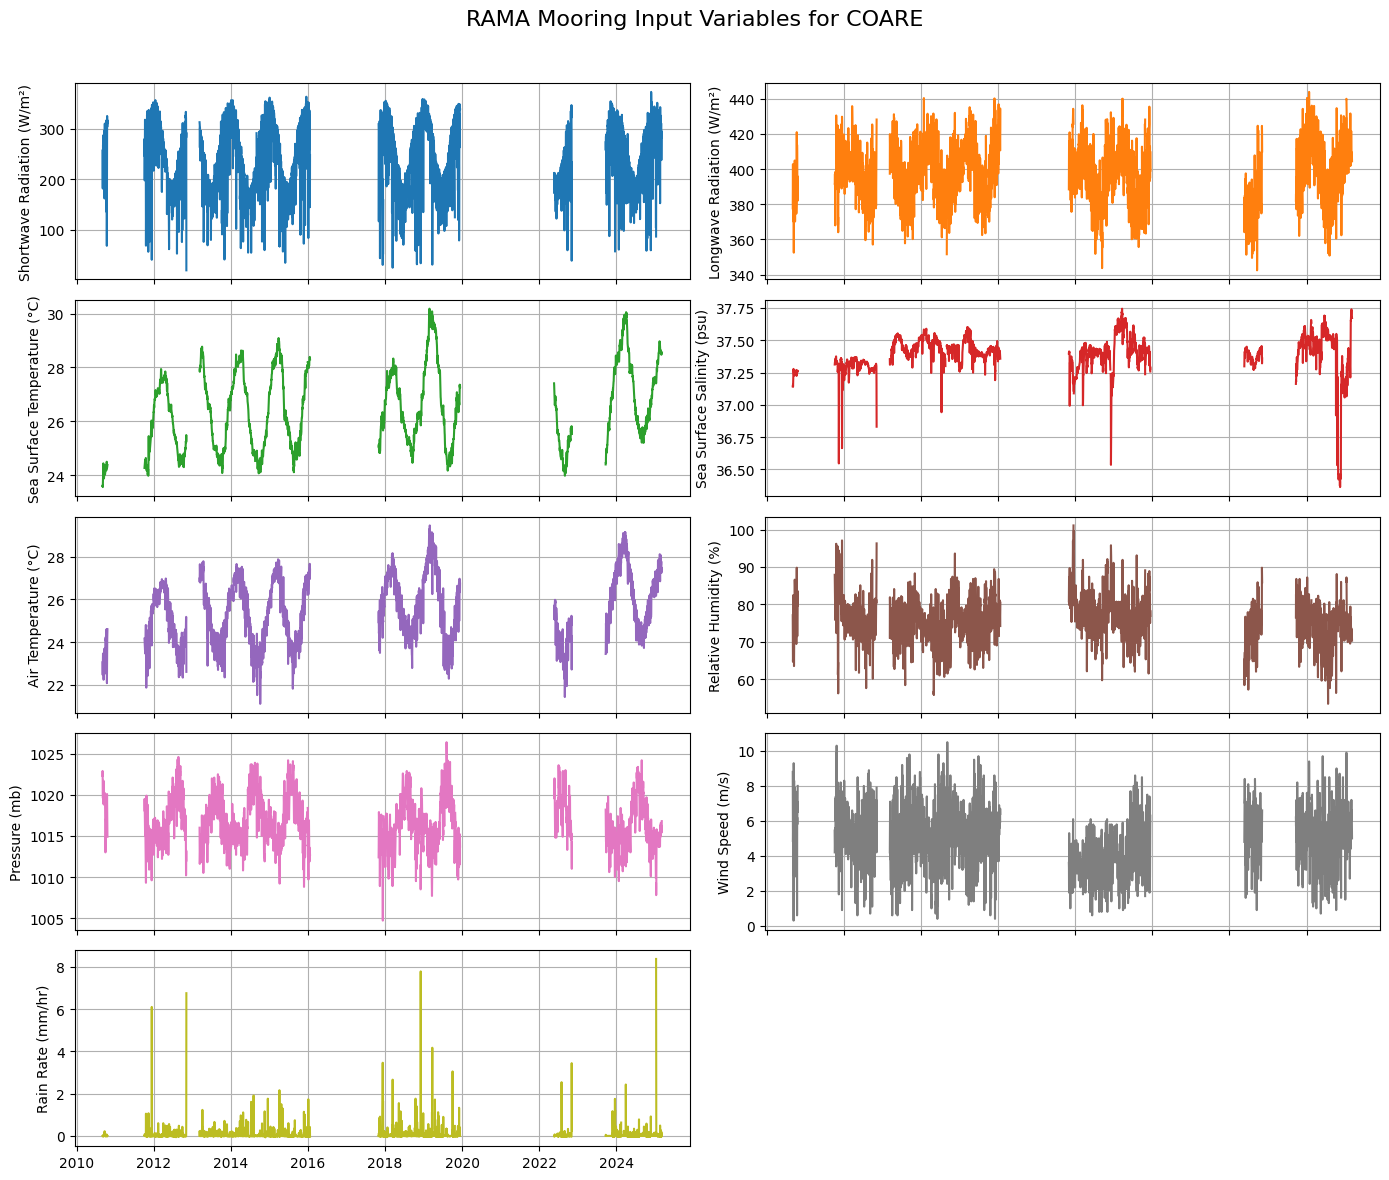

In [334]:
# -------------------------------------------------------
# Plot time series
fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex=True)
axes = axes.ravel()

vars_to_plot = ["sw", "lw", "sst", "sss", "airt", "rh", "pres", "wsp", "rain"]
titles = [
    "Shortwave Radiation (W/m²)", "Longwave Radiation (W/m²)",
    "Sea Surface Temperature (°C)", "Sea Surface Salinity (psu)",
    "Air Temperature (°C)", "Relative Humidity (%)",
    "Pressure (mb)", "Wind Speed (m/s)", "Rain Rate (mm/hr)"
]
df1   = df.asfreq('1D')
for i, var in enumerate(vars_to_plot):
    axes[i].plot(df1.index, df1[var], label=var, color="C"+str(i))
    axes[i].set_ylabel(titles[i])
    axes[i].grid(True)

# Remove empty subplot if odd number of plots
fig.delaxes(axes[-1])

fig.suptitle("RAMA Mooring Input Variables for COARE", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Save input** → export formatted DataFrame to CSV.

In [335]:
coare_input.to_csv('/home/rohit/Downloads/test_data.txt',index=False,sep=",")

**Run COARE algorithm** *(optional, depending on workflow)*.

In [336]:
%run /home/rohit/Downloads/coare36_sample.py

/home/rohit/Downloads/coare36_sample.py:752: RuntimeWarning: invalid value encountered in power
  psi = - ((1 + 0.6667 * zeta) ** 1.5 + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
/home/rohit/Downloads/coare36_sample.py:495: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ik = np.array(np.where(rr[iice] > np.logical_and(0.135,rr[iice]) <= 2.5))
/home/rohit/Downloads/coare36_sample.py:498: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ik = np.array(np.where(rr[iice] > np.logical_and(2.5,rr[iice]) <= 1000))
/home/rohit/Downloads/coare36_sample.py:716: RuntimeWarning: invalid value encountered in power
  wc_frac = 0.00073 * (U10N - 2) ** 1.43


**Read output** → load COARE results from a text/CSV file.

In [337]:
flux       = pd.read_csv('/home/rohit/Downloads/test_output.txt',delimiter='\t',index_col=False)
flux.index = time

**Calculate net flux**

In [343]:
net = flux.sw_net + flux.lw_net - flux.hsb - flux.hlb

**Plot results** → visualize fluxes and coefficients for interpretation.

In [339]:
flux

,# tau,hsb,hlb,lw_net,sw_net
time,,,,,
2010-09-01 12:00:00,0.116580,-4.925660,-134.851762,-59.201966,256.88
2010-09-02 12:00:00,0.050765,-7.623302,-154.678788,-42.198530,192.76
2010-09-03 12:00:00,0.029194,-7.139686,-133.686627,-34.252354,183.77
2010-09-04 12:00:00,0.036778,-4.727268,-136.493594,-45.019450,181.73
2010-09-05 12:00:00,0.027944,-1.807097,-106.262933,-66.519137,265.81
...,...,...,...,...,...
2025-03-03 12:00:00,0.046414,-8.854599,-164.248530,-57.677689,238.08
2025-03-04 12:00:00,0.057429,-7.017917,-182.262575,-57.834723,262.24
2025-03-05 12:00:00,0.049721,-6.925608,-176.817318,-61.461129,295.47


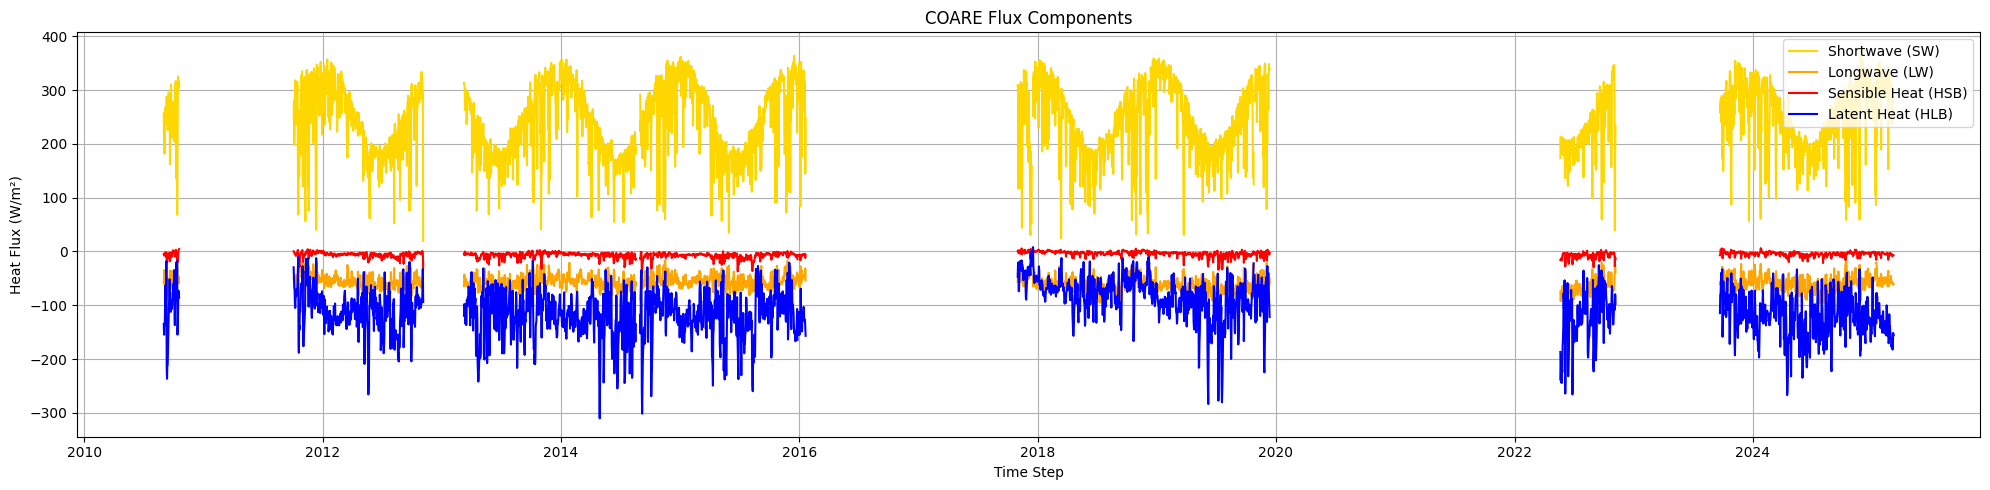

In [340]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Plot COARE output flux components: SW, LW, sensible, latent heat
with wind stress on secondary axis
"""

# Build plot
fig, ax1 = plt.subplots(figsize=(20,5))

flux1 = flux.asfreq('1D')
# Heat flux components
ax1.plot(flux1.index, flux1["sw_net"], label="Shortwave (SW)", color="gold")
ax1.plot(flux1.index, flux1["lw_net"], label="Longwave (LW)", color="orange")
ax1.plot(flux1.index, flux1["hsb"], label="Sensible Heat (HSB)", color="red")
ax1.plot(flux1.index, flux1["hlb"], label="Latent Heat (HLB)", color="blue")
#ax1.plot(flux1.index, flux1["sw_net"] + flux1["lw_net"] + flux1["hsb"] + flux1["hlb"], label="Net Flux", color="black")

ax1.set_xlabel("Time Step")
ax1.set_ylabel("Heat Flux (W/m²)")
ax1.grid(True)

# Secondary axis for wind stress
#ax2 = ax1.twinx()
#ax2.plot(flux1.index, flux1["# tau"], label="Wind Stress (Tau)", color="black", linestyle="--")
#ax2.set_ylabel("Wind Stress (N/m²)")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax1.legend(lines1 , labels1 , loc="upper right")
plt.title("COARE Flux Components")
plt.tight_layout()
plt.show()

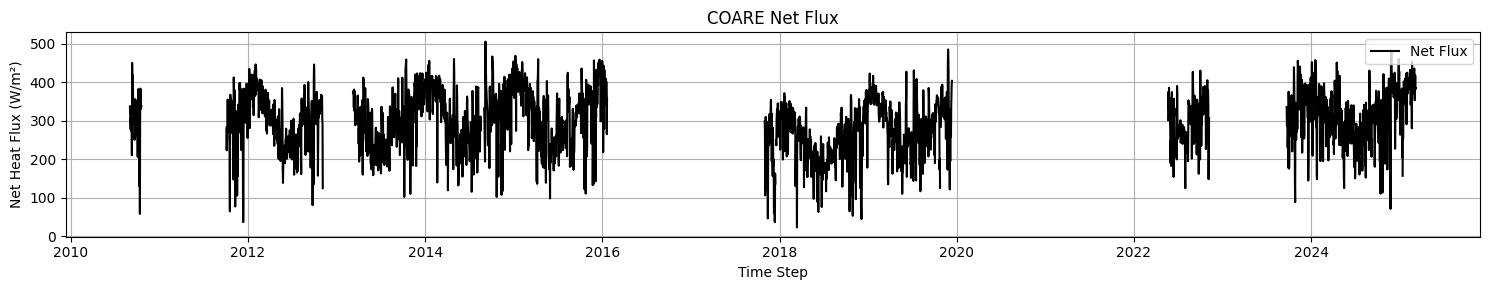

In [346]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Plot COARE output flux components: SW + LW + sensible + latent heat
with wind stress on secondary axis
"""

# Build plot
fig, ax1 = plt.subplots(figsize=(15,3))

net1 = net.asfreq('1D')
# Heat flux components
ax1.plot(net1.index, net1, label="Net Flux", color="black")

ax1.set_xlabel("Time Step")
ax1.set_ylabel("Net Heat Flux (W/m²)")
ax1.grid(True)

# Secondary axis for wind stress
#ax2 = ax1.twinx()
#ax2.plot(flux1.index, flux1["# tau"], label="Wind Stress (Tau)", color="blue", linestyle="--")
#ax2.set_ylabel("Wind Stress (N/m²)")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax1.legend(lines1 , labels1 , loc="upper right")
plt.title("COARE Net Flux")
plt.tight_layout()
plt.show()